In [1]:
import math
import numpy as np
import math
from datasets import load_dataset

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import json
import os
import time
import random
import ast

/Users/alessandrococcia/Desktop/MNLP HW 1/Cultural_classification/.venv-py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Leggi il dataset originale una sola volta
silver_dataset = pd.read_csv('../datasets/silver_unicum.csv')
gold_dataset = pd.read_csv('../datasets/gold_unicum.csv')


In [ ]:
def to_quantili(train_dataset, val_dataset, in_column_name, out_column_name, n_quantili):
    #Taken a numerical column as input, <n_quantili> bins are created. 
    #The "quantilization" is performed based just on train_dataset values, to avoid data leakage
    #The bins are then applied both to the train and val dataset
    #Finally the old numerical columns are dropped
    
    bins_edges = pd.qcut(train_dataset[in_column_name], q=n_quantili, retbins=True)[1]
    train_dataset[out_column_name] = pd.cut(train_dataset[in_column_name], bins=bins_edges, include_lowest=True, duplicates='drop')
    val_dataset[out_column_name] = pd.cut(val_dataset[in_column_name], bins=bins_edges, include_lowest=True, duplicates='drop')

    train_dataset.drop(columns=in_column_name, inplace=True)
    val_dataset.drop(columns=in_column_name, inplace=True)

    return train_dataset, val_dataset


In [ ]:
#If entry == something i just punt one, regarding of the content
str_to_one = lambda x: 0 if len(x) == 1 else 1
silver_dataset['countryLabel'] = silver_dataset['countryLabel'].apply(str_to_one)
silver_dataset['subclass_ofLabel'] = silver_dataset['subclass_ofLabel'].apply(str_to_one)
gold_dataset['countryLabel'] = gold_dataset['countryLabel'].apply(str_to_one)
gold_dataset['subclass_ofLabel'] = gold_dataset['subclass_ofLabel'].apply(str_to_one)


In [ ]:
label_columns = ['label_cultural agnostic', 'label_cultural exclusive', 'label_cultural representative']

In [ ]:
print(silver_dataset.columns)
print(gold_dataset.columns)

Index(['item', 'name', 'type', 'category', 'subcategory', 'label',
       'countryLabel', 'subclass_ofLabel', 'text_distribution', 'std_text',
       'avg_text', 'len', 'entropy_text', 'gini_text', 'sum_over_texts',
       'ref_distribution', 'std_ref', 'avg_ref', 'sum_over_ref', 'entropy_ref',
       'gini_ref', 'h_adj_descr', 'h_nat_descr', 'h_adj_engtext',
       'h_nat_engtext'],
      dtype='object')
Index(['item', 'name', 'type', 'category', 'subcategory', 'label',
       'countryLabel', 'subclass_ofLabel', 'text_distribution', 'std_text',
       'avg_text', 'len', 'entropy_text', 'gini_text', 'sum_over_texts',
       'ref_distribution', 'std_ref', 'avg_ref', 'sum_over_ref', 'entropy_ref',
       'gini_ref', 'h_adj_descr', 'h_nat_descr', 'h_adj_engtext',
       'h_nat_engtext'],
      dtype='object')


In [ ]:
#drop unnecessary columns
columns_to_quantili = ['len']

unnecessary_columns =  [ 'item', 'name', 'text_distribution', 'ref_distribution', 'std_text', 'avg_text', 'entropy_text', 'gini_text', 'sum_over_texts',
                         'sum_over_ref', 'entropy_ref', 'gini_ref', 'h_adj_engtext',
                        'h_nat_engtext'
                    ]
silver_dataset = silver_dataset.drop(columns=unnecessary_columns)
gold_dataset = gold_dataset.drop(columns=unnecessary_columns)

In [ ]:
#Divide numerical features in classes based on quantili

for feature in columns_to_quantili:
    silver_dataset, gold_dataset = to_quantili(silver_dataset, gold_dataset, feature, "bin_"+feature, 4)

In [ ]:
print(silver_dataset.columns)

Index(['type', 'category', 'subcategory', 'label', 'countryLabel',
       'subclass_ofLabel', 'std_ref', 'avg_ref', 'h_adj_descr', 'h_nat_descr',
       'bin_len'],
      dtype='object')


In [ ]:
categorical_columns = silver_dataset.columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(silver_dataset[categorical_columns])
encoded_train = encoder.transform(silver_dataset[categorical_columns])
encoded_eval = encoder.transform(gold_dataset[categorical_columns])
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns), index=silver_dataset.index)
encoded_eval_df = pd.DataFrame(encoded_eval, columns=encoder.get_feature_names_out(categorical_columns), index=gold_dataset.index)

training_dataset = silver_dataset.drop(columns=categorical_columns)
training_dataset = pd.concat([training_dataset, encoded_train_df], axis=1)
evaluation_dataset = gold_dataset.drop(columns=categorical_columns)
evaluation_dataset = pd.concat([evaluation_dataset, encoded_eval_df], axis=1)

X_train = training_dataset.drop(columns=label_columns)
y_train = training_dataset[label_columns]
X_test = evaluation_dataset.drop(columns=label_columns)
y_test = evaluation_dataset[label_columns]

rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
score = f1_score(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)
print("ACCURACY: ", acc)



ACCURACY:  0.6956521739130435


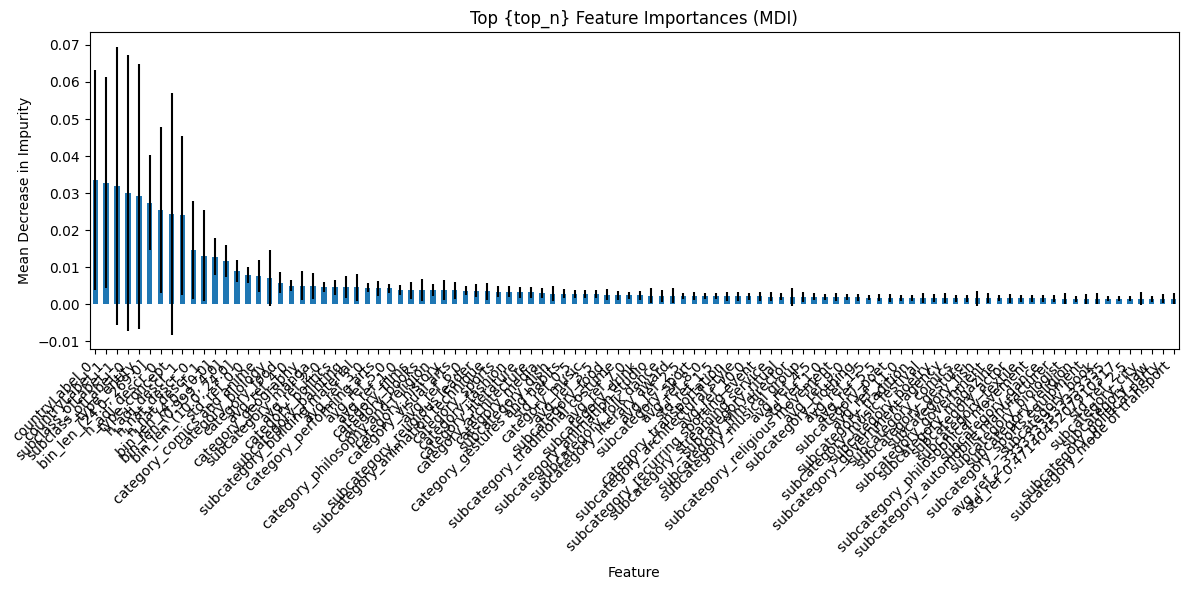

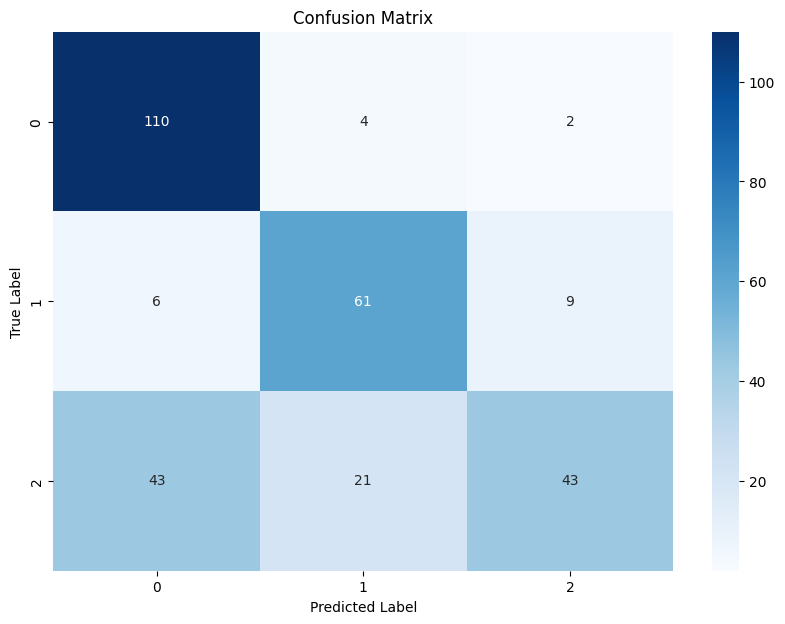

In [ ]:
#ANALITICS

# Crea i nomi delle feature (se non li hai già)
feature_names = X_train.columns.tolist()

# Calcola le importanze medie e deviazione standard tra tutti gli alberi
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

# Serie ordinata con le feature
forest_importances = pd.Series(importances, index=feature_names)

# # Ordina e prendi le top 20
top_n = 100
# print(len(forest_importances))
top_features = forest_importances.sort_values(ascending=False).head(top_n)
# worst_features = forest_importances.sort_values(ascending=True).head(10).index.tolist()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
top_features.plot.bar(yerr=std[[feature_names.index(f) for f in top_features.index]], ax=ax)
ax.set_title("Top {top_n} Feature Importances (MDI)")
ax.set_ylabel("Mean Decrease in Impurity")
ax.set_xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()